In [ ]:
#data is VCD , frame extracted by 5 fps and frame degradation for input in random frames

Loading data

In [ ]:
%pip install kaggle

In [3]:
# Move kaggle.json to the correct directory and set permissions
import shutil
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [ ]:
import kagglehub

# Download latest version

%kaggle datasets download -d kp2292/targetfrm



Dataset URL: https://www.kaggle.com/datasets/kp2292/targetfrm
License(s): unknown


In [ ]:
%kaggle datasets download -d kp2292/inputfrm

Dataset URL: https://www.kaggle.com/datasets/kp2292/inputfrm
License(s): unknown


In [7]:
import zipfile
import os

def unzip_file(zip_file_path,Extract_path):
  if not os.path.exists(Extract_path):
    os.makedirs(Extract_path)

  with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
    zip_ref.extractall(Extract_path)
    print("Extracted!!")

unzip_file('/content/targetfrm.zip','/content/Data')

Extracted!!


In [8]:
import zipfile
import os

def unzip_file(zip_file_path,Extract_path):
  if not os.path.exists(Extract_path):
    os.makedirs(Extract_path)

  with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
    zip_ref.extractall(Extract_path)
    print("Extracted!!")

unzip_file('/content/inputfrm.zip','/content/Data')

Extracted!!


In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class VCDFramesDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform

        self.samples = []

        for category in os.listdir(input_dir):
            category_input_path = os.path.join(input_dir, category)
            category_target_path = os.path.join(target_dir, category)

            if not os.path.isdir(category_input_path):
                continue

            for video_id in os.listdir(category_input_path):
                input_video_path = os.path.join(category_input_path, video_id)
                target_video_path = os.path.join(category_target_path, video_id)

                if not os.path.isdir(input_video_path):
                    continue

                for frame in os.listdir(input_video_path):
                    lq_frame = os.path.join(input_video_path, frame)
                    hq_frame = os.path.join(target_video_path, frame)

                    if os.path.exists(hq_frame):
                        self.samples.append((lq_frame, hq_frame))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lq_path, hq_path = self.samples[idx]
        lq_img = Image.open(lq_path).convert("RGB")
        hq_img = Image.open(hq_path).convert("RGB")

        if self.transform:
            lq_img = self.transform(lq_img)
            hq_img = self.transform(hq_img)

        return lq_img, hq_img


In [10]:
#Transformations
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])


In [11]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 9, 1, 4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[ResBlock(64) for _ in range(5)])
        self.conv_mid = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Identity()  # No upsampling
        self.final = nn.Conv2d(64, 3, 3, 1, 1)  # Just reduce channels

    def forward(self, x):
        x1 = self.initial(x)
        x2 = self.res_blocks(x1)
        x3 = self.conv_mid(x2)
        x = x1 + x3
        x = self.upsample(x)
        return self.final(x)


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_ch, out_ch, stride):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, stride, 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            block(64, 64, 2),
            block(64, 128, 1),
            block(128, 128, 2),
            block(128, 256, 1),
            block(256, 256, 2),
            block(256, 512, 1),
            block(512, 512, 2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.model(x)


In [13]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Dataset
dataset = VCDFramesDataset('/content/Data/LQ_frames/input', '/content/Data/HQ_frames/target', transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Losses
adv_loss = nn.BCEWithLogitsLoss()
pixel_loss = nn.MSELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Training
epochs = 10
for epoch in range(epochs):

    print(f"\n Epoch [{epoch+1}/{epochs}]")
    for i, (lq, hq) in enumerate(loader):
        lq, hq = lq.to(device), hq.to(device)

        valid = torch.ones((lq.size(0), 1), device=device)
        fake = torch.zeros((lq.size(0), 1), device=device)

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        gen_hr = generator(lq)
        loss_pixel = pixel_loss(gen_hr, hq)
        pred_fake = discriminator(gen_hr)
        loss_G = loss_pixel + 1e-3 * adv_loss(pred_fake, valid)
        loss_G.backward()
        optimizer_G.step()

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        pred_real = discriminator(hq)
        pred_fake = discriminator(gen_hr.detach())
        loss_D = (adv_loss(pred_real, valid) + adv_loss(pred_fake, fake)) / 2
        loss_D.backward()
        optimizer_D.step()

        if i % 20 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}] "
                  f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

# Save model
torch.save(generator.state_dict(), "gan_generator.pth")
torch.save(discriminator.state_dict(), "gan_discriminator.pth")



 Epoch [1/10]
[Epoch 1/10] [Batch 0] [D loss: 0.6972] [G loss: 0.5152]
[Epoch 1/10] [Batch 20] [D loss: 0.6387] [G loss: 0.0217]
[Epoch 1/10] [Batch 40] [D loss: 0.6163] [G loss: 0.0180]
[Epoch 1/10] [Batch 60] [D loss: 0.6670] [G loss: 0.0101]
[Epoch 1/10] [Batch 80] [D loss: 0.8310] [G loss: 0.0064]
[Epoch 1/10] [Batch 100] [D loss: 0.6252] [G loss: 0.0100]
[Epoch 1/10] [Batch 120] [D loss: 0.4833] [G loss: 0.0236]
[Epoch 1/10] [Batch 140] [D loss: 0.5141] [G loss: 0.0099]
[Epoch 1/10] [Batch 160] [D loss: 0.6692] [G loss: 0.0057]
[Epoch 1/10] [Batch 180] [D loss: 0.7388] [G loss: 0.0038]
[Epoch 1/10] [Batch 200] [D loss: 0.6522] [G loss: 0.0056]
[Epoch 1/10] [Batch 220] [D loss: 0.4467] [G loss: 0.0083]
[Epoch 1/10] [Batch 240] [D loss: 0.5756] [G loss: 0.0071]
[Epoch 1/10] [Batch 260] [D loss: 0.6254] [G loss: 0.0121]
[Epoch 1/10] [Batch 280] [D loss: 0.6842] [G loss: 0.0105]
[Epoch 1/10] [Batch 300] [D loss: 0.6959] [G loss: 0.0037]
[Epoch 1/10] [Batch 320] [D loss: 0.4392] [G lo

In [14]:
import torch

# Load generator model
generator = Generator()  # Make sure to use the same architecture
generator.load_state_dict(torch.load('/content/gan_generator.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
generator.eval()


Generator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0

In [15]:
from torchvision import transforms
from PIL import Image
import os

# Transform for input (low-quality image)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def load_test_images(test_folder, max_images=10):
    images = []
    paths = sorted(os.listdir(test_folder))[:max_images]
    for img_name in paths:
        img_path = os.path.join(test_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
        images.append((img_name, img_tensor))
    return images


In [16]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

test_folder = "/content/Data/LQ_frames/input/th/0380a333cb0fef69001fb4260e2a705f_1920x1080_30"
output_folder = "/content/test_results"
os.makedirs(output_folder, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)

test_images = load_test_images(test_folder)

for img_name, lq_img in test_images:
    lq_img = lq_img.to(device)
    with torch.no_grad():
        gen_img = generator(lq_img)

    # Save the output
    vutils.save_image(gen_img, os.path.join(output_folder, f"generated_{img_name}"))
    vutils.save_image(lq_img, os.path.join(output_folder, f"input_{img_name}"))

print("✅ Inference complete. Generated images saved in:", output_folder)


✅ Inference complete. Generated images saved in: /content/test_results


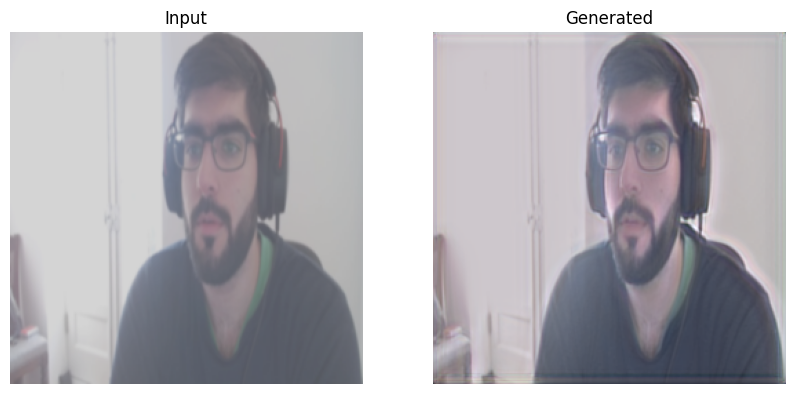

In [29]:
def show_images(img1_path, img2_path, title1="Input", title2="Generated"):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

# Example:
show_images(
    "/content/test_results/input_007.png",
    "/content/test_results/generated_007.png"
)


In [20]:
# Reconstruct Videos from Frames
import cv2
import os
from natsort import natsorted

def frames_to_video(frames_folder, output_path, fps=5):
    frames = natsorted([f for f in os.listdir(frames_folder) if f.endswith(".png")])
    if not frames:
        print("No frames found!")
        return

    first_frame = cv2.imread(os.path.join(frames_folder, frames[0]))
    height, width, _ = first_frame.shape

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for frame in frames:
        img = cv2.imread(os.path.join(frames_folder, frame))
        out.write(img)

    out.release()
    print(f"🎬 Video saved at: {output_path}")


In [21]:
frames_to_video("/content/test_results", "/content/generated_video.mp4", fps=5)
frames_to_video("/content/Data/LQ_frames/input/th/0380a333cb0fef69001fb4260e2a705f_1920x1080_30", "/content/input_video.mp4", fps=5)


🎬 Video saved at: /content/generated_video.mp4
🎬 Video saved at: /content/input_video.mp4


In [24]:
import cv2
import os
from natsort import natsorted

def create_side_by_side_video(input_folder, output_folder, save_path, fps=5):
    input_frames = natsorted([f for f in os.listdir(input_folder) if f.endswith(".png")])
    output_frames = natsorted([f for f in os.listdir(output_folder) if f.endswith(".png") or f.startswith("generated_")])

    if not input_frames or not output_frames:
        print("Missing frames in one of the folders.")
        return

    # Read first frame to get size
    frame1 = cv2.imread(os.path.join(input_folder, input_frames[0]))
    frame2 = cv2.imread(os.path.join(output_folder, output_frames[0]))

    # Resize if necessary to match sizes
    if frame1.shape != frame2.shape:
        frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

    height, width, _ = frame1.shape
    video_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width * 2, height))

    for in_f, out_f in zip(input_frames, output_frames):
        frame1 = cv2.imread(os.path.join(input_folder, in_f))
        frame2 = cv2.imread(os.path.join(output_folder, out_f))

        if frame1.shape != frame2.shape:
            frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

        side_by_side = cv2.hconcat([frame1, frame2])
        video_writer.write(side_by_side)

    video_writer.release()
    print(f"✅ Side-by-side video saved at: {save_path}")


In [26]:
create_side_by_side_video(
    input_folder="/content/Data/LQ_frames/input/th/0380a333cb0fef69001fb4260e2a705f_1920x1080_30",
    output_folder="/content/test_results",
    save_path="/content/comparison_video.mp4",
    fps=5
)


✅ Side-by-side video saved at: /content/comparison_video.mp4


In [ ]:
%pip install scikit-image


In [33]:
import cv2
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from natsort import natsorted

def calculate_metrics(input_folder, output_folder):
    input_images = natsorted([f for f in os.listdir(input_folder) if f.endswith(".png")])
    output_images = natsorted([f for f in os.listdir(output_folder) if f.endswith(".png")])

    total_ssim = 0
    total_psnr = 0
    count = 0

    for inp, out in zip(input_images, output_images):
        inp_path = os.path.join(input_folder, inp)
        out_path = os.path.join(output_folder, out)

        img1 = cv2.imread(inp_path)
        img2 = cv2.imread(out_path)

        if img1 is None or img2 is None:
            print(f"Skipping due to error: {inp} or {out}")
            continue

        # Resize output image to match input
        if img1.shape != img2.shape:
            img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

        # Convert to grayscale for SSIM
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        score_ssim = ssim(gray1, gray2)
        score_psnr = psnr(img1, img2)

        total_ssim += score_ssim
        total_psnr += score_psnr
        count += 1

    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count

    print(f" Average SSIM: {avg_ssim:.4f}")
    print(f" Average PSNR: {avg_psnr:.2f} dB")


calculate_metrics(
    "/content/Data/LQ_frames/input/th/0380a333cb0fef69001fb4260e2a705f_1920x1080_30",  # LQ inputs
    "/content/test_results"                             # Generated HQ
)


 Average SSIM: 0.8820
 Average PSNR: 21.85 dB


In [30]:
#Set Up Video Capture

import cv2
from PIL import Image
import numpy as np

# Preprocessing transforms (adjust as per your training)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [32]:
# def postprocess(tensor):
#     img = tensor.detach().cpu().squeeze().permute(1, 2, 0).numpy()
#     img = (img * 255).clip(0, 255).astype(np.uint8)
#     return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# cap = cv2.VideoCapture(0)  # 0 for default webcam

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     input_img = preprocess(frame).unsqueeze(0).to(device)  # (1, 3, 256, 256)

#     with torch.no_grad():
#         output_img = generator(input_img)

#     result = postprocess(output_img)
#     frame_resized = cv2.resize(frame, (256, 256))

#     combined = np.hstack((frame_resized, result))
#     cv2.imshow("Live LQ vs Enhanced HQ", combined)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
